In [232]:
%pylab inline
import h5py

# Import the usual modules
from datetime import datetime, timedelta
import ASI # for cnv_azel2latlon
import pytz
import scipy.sparse as sp
import scipy.sparse.linalg # Why oh why is this necessary
import os
import glob
from mpl_toolkits.basemap import Basemap
import subprocess
from collections import deque
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import dates

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [311]:
yearmoda = '20150318'
fns = glob.glob('/home/bhardin2/koki_meteor_radar/mmaria*%s.h5' % yearmoda)
fns

daydir = '/home/bhardin2/koki_meteor_radar/%s' % yearmoda
try:
    os.mkdir(daydir)
except Exception as e:
    print 'Ignored Error: %s' % e

Ignored Error: [Errno 17] File exists: '/home/bhardin2/koki_meteor_radar/20150318'


In [332]:
altmin = 94.
altmax = 96.

timestep_fit = 1800 # this is actually the interval of time. samples are defined below.
startstop_hr = None
Nx = 25
Ny = 25
outlier_thresh = 2.0 # remove points that have chi2 contributions beyond this.
oldthresh = 60.
chi2mult = 1.0
tol0=1e-4
tol1 = 1e-1
tol2 = 1e-2 # 1e-1
L=5
L2 = 10
printstuffinner = False
printstuffouter = False
maxiters=100
lam1small = 1e-4
lam0guess = 1e-5
lam0interior = 1e10
lam1interior = 1
Nmc = 100
estimate_vertical_wind=False
calculate_uncertainty=False
vertweight=1. # set to 1 for no effect.
error_mult = 1. # artificial multiplier on input uncertainties
error_add  = 0. # artifical addition to input uncertainties (roughly but not quite m/s)

In [333]:
# Load up some values from the file
# (It is assumed that all files are from the same day)
fn = fns[0]
f = h5py.File(fn,'r')
d = f['Meteor Parameters']
lon0,lat0,_ = d.attrs['OTHER'][0][3] # rx lon,lat

t_0 = datetime(1970,1,1) + timedelta(seconds=float(d[0][2]))
t_0_midnight = datetime(t_0.year, t_0.month, t_0.day)
t_1 = datetime(1970,1,1) + timedelta(seconds=float(d[-1][2]))

# Load all rx locations
lon0vec = []
lat0vec = []
for fni in range(len(fns)):
    fn = fns[fni]
    f = h5py.File(fn,'r')
    d = f['Meteor Parameters']
    ilon0,ilat0,_ = d.attrs['OTHER'][0][3] # rx lon,lat    
    lon0vec.append(ilon0)
    lat0vec.append(ilat0)
lon0vec = array(list(set(lon0vec)))
lat0vec = array(list(set(lat0vec)))

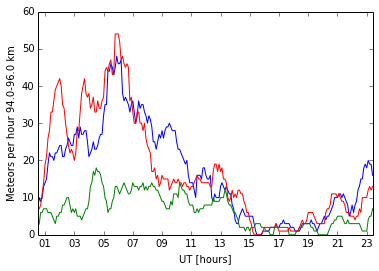

In [314]:
# Make a plot of meteors/hr
for fni in range(len(fns)):
    fn = fns[fni]
    f = h5py.File(fn,'r')
    d = f['Meteor Parameters']
    t = array([datetime(1970,1,1) + timedelta(seconds=float(d[i][2])) for i in range(len(d))])
    alt = array([d[i][11] for i in range(len(d))])
    idx = logical_and(alt > altmin , alt <= altmax)
    ti = t[idx]
    tstep = 0.1 # hours
    N = int(23./tstep)
    tvec = array([datetime(t[0].year, t[0].month, t[0].day) + timedelta(hours=0.5 + i*tstep) for i in range(N)])
    mvec = zeros(len(tvec))
    td = timedelta(hours=0.5)
    for j in range(len(tvec)):
        tmpi = logical_and(ti > tvec[j]-td, ti < tvec[j]+td)
        mvec[j] = sum(tmpi)
    plot(tvec,mvec,'-')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
xlabel('UT [hours]')
ylabel('Meteors per hour %.1f-%.1f km' % (altmin,altmax))

In [410]:
# Define time intervals
thr_vec = arange(0.5,12.1,0.5) # center of time intervals
#thr_vec = array([2.])
thrmin_vec = thr_vec - timestep_fit/2./3600. # beginning of intervals
thrmax_vec = thr_vec + timestep_fit/2./3600. # end of intervals
print thrmin_vec
print thrmax_vec

[  0.25   0.75   1.25   1.75   2.25   2.75   3.25   3.75   4.25   4.75
   5.25   5.75   6.25   6.75   7.25   7.75   8.25   8.75   9.25   9.75
  10.25  10.75  11.25  11.75]
[  0.75   1.25   1.75   2.25   2.75   3.25   3.75   4.25   4.75   5.25
   5.75   6.25   6.75   7.25   7.75   8.25   8.75   9.25   9.75  10.25
  10.75  11.25  11.75  12.25]


In [395]:
# Define grid in terms of latitude and longitude
# TODO: Is it worth going to x,y or can we redefine gradients appropriately? Probably the latter.
lonmin = min(lon0vec)-1
lonmax = max(lon0vec)+1
latmin = min(lat0vec)-1
latmax = max(lat0vec)+1

windfield = {}
windfield['t'] = []
windfield['lat'] = []
windfield['lon'] = []
windfield['u'] = []
windfield['v'] = []
windfield['w'] = []
windfield['lat_measured'] = []
windfield['lon_measured'] = []
windfield['u_sigma'] = []
windfield['v_sigma'] = []
windfield['w_sigma'] = []
windfield['lam0'] = []
windfield['lam1'] = []

numfailed = 0

xs = linspace(lonmin, lonmax, Nx)
ys = linspace(latmin, latmax, Ny)

[X,Y] = meshgrid(xs,ys)
x = reshape(X,(Nx*Ny,))
y = reshape(Y,(Nx*Ny,))
    
for timeindex in range(len(thrmin_vec)):
    thrmin = thrmin_vec[timeindex]
    thrmax = thrmax_vec[timeindex]
    
    tmin = t_0_midnight + timedelta(hours=thrmin)
    tmax = t_0_midnight + timedelta(hours=thrmax)

    # Preconstruct the D matrix (regularization penalty matrix)
    def tand(x):
        return tan(pi/180.*x)
    def cosd(x):
        return cos(pi/180.*x)
    def sind(x):
        return sin(pi/180.*x)
    # Dxx measures x curvature, Dyy measures y curvature, Dxy measures xy curvature, Dyx measures yx curvature
    # Dx measures y gradient, Dy measures y gradient
    # D matrix will comprise these in some ratio defined by lambda_1

    # Construct Dxx
    Di = zeros(9*(Nx-2)*Ny)
    Dj = zeros(9*(Nx-2)*Ny)
    Dv = zeros(9*(Nx-2)*Ny)
    count = 0
    for idx in range(Nx*Ny):
        i,j = unravel_index(idx, (Ny,Nx))
        ileft = i
        iright = i
        jleft = j-1
        jright = j+1
        if (ileft >= 0 and ileft < Ny and iright >=0 and iright < Ny and \
            jleft >= 0 and jleft < Nx and jright >=0 and jright < Nx):
            dx = (X[i,jright] - X[i,j]) * 111. * cosd(Y[i,j])
            dy = (Y[iright,j] - Y[i,j]) * 111.        
            idxleft = ravel_multi_index((ileft,jleft),(Ny,Nx))
            idxright = ravel_multi_index((iright,jright),(Ny,Nx))
            Di[count:count+3] = [idx,idx,idx]
            Dj[count:count+3] = [idxleft,idx,idxright]
            Dv[count:count+3] = array([-1,2,-1])/dx**2
            count += 3
            Di[count:count+3] = [Nx*Ny + idx,    Nx*Ny + idx,Nx*Ny + idx]
            Dj[count:count+3] = [Nx*Ny + idxleft,Nx*Ny + idx,Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/dx**2
            count += 3
            Di[count:count+3] = [2*Nx*Ny + idx,    2*Nx*Ny + idx,2*Nx*Ny + idx]
            Dj[count:count+3] = [2*Nx*Ny + idxleft,2*Nx*Ny + idx,2*Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/dx**2 * vertweight
            count += 3
    Dxx = sp.coo_matrix((Dv,[Di,Dj]), (3*Nx*Ny,3*Nx*Ny))

    # Construct Dyy
    Di = zeros(9*(Nx-2)*Ny)
    Dj = zeros(9*(Nx-2)*Ny)
    Dv = zeros(9*(Nx-2)*Ny)
    count = 0
    for idx in range(Nx*Ny):
        i,j = unravel_index(idx, (Ny,Nx))
        ileft = i-1
        iright = i+1
        jleft = j
        jright = j
        if (ileft >= 0 and ileft < Ny and iright >=0 and iright < Ny and \
            jleft >= 0 and jleft < Nx and jright >=0 and jright < Nx):
            dx = (X[i,jright] - X[i,j]) * 111. * cosd(Y[i,j])
            dy = (Y[iright,j] - Y[i,j]) * 111. 
            idxleft = ravel_multi_index((ileft,jleft),(Ny,Nx))
            idxright = ravel_multi_index((iright,jright),(Ny,Nx))
            Di[count:count+3] = [idx,idx,idx]
            Dj[count:count+3] = [idxleft,idx,idxright]
            Dv[count:count+3] = array([-1,2,-1])/dy**2
            count += 3
            Di[count:count+3] = [Nx*Ny + idx,    Nx*Ny + idx,Nx*Ny + idx]
            Dj[count:count+3] = [Nx*Ny + idxleft,Nx*Ny + idx,Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/dy**2
            count += 3
            Di[count:count+3] = [2*Nx*Ny + idx,    2*Nx*Ny + idx,2*Nx*Ny + idx]
            Dj[count:count+3] = [2*Nx*Ny + idxleft,2*Nx*Ny + idx,2*Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/dy**2 * vertweight
            count += 3
    Dyy = sp.coo_matrix((Dv,[Di,Dj]), (3*Nx*Ny,3*Nx*Ny))

    # Construct Dxy
    Di = zeros(9*(Nx-2)*(Ny-2))
    Dj = zeros(9*(Nx-2)*(Ny-2))
    Dv = zeros(9*(Nx-2)*(Ny-2))
    count = 0
    for idx in range(Nx*Ny):
        i,j = unravel_index(idx, (Ny,Nx))
        ileft = i-1
        iright = i+1
        jleft = j-1
        jright = j+1
        if (ileft >= 0 and ileft < Ny and iright >=0 and iright < Ny and \
            jleft >= 0 and jleft < Nx and jright >=0 and jright < Nx):
            dx = (X[i,jright] - X[i,j]) * 111. * cosd(Y[i,j])
            dy = (Y[iright,j] - Y[i,j]) * 111. 
            idxleft = ravel_multi_index((ileft,jleft),(Ny,Nx))
            idxright = ravel_multi_index((iright,jright),(Ny,Nx))
            Di[count:count+3] = [idx,idx,idx]
            Dj[count:count+3] = [idxleft,idx,idxright]
            Dv[count:count+3] = array([-1,2,-1])/(dx*dy)
            count += 3
            Di[count:count+3] = [Nx*Ny + idx,    Nx*Ny + idx,Nx*Ny + idx]
            Dj[count:count+3] = [Nx*Ny + idxleft,Nx*Ny + idx,Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/(dx*dy)
            count += 3
            Di[count:count+3] = [2*Nx*Ny + idx,    2*Nx*Ny + idx,2*Nx*Ny + idx]
            Dj[count:count+3] = [2*Nx*Ny + idxleft,2*Nx*Ny + idx,2*Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/(dx*dy) * vertweight
            count += 3
    Dxy = sp.coo_matrix((Dv,[Di,Dj]), (3*Nx*Ny,3*Nx*Ny))

    # Construct Dyx
    Di = zeros(9*(Nx-2)*(Ny-2))
    Dj = zeros(9*(Nx-2)*(Ny-2))
    Dv = zeros(9*(Nx-2)*(Ny-2))
    count = 0
    for idx in range(Nx*Ny):
        i,j = unravel_index(idx, (Ny,Nx))
        ileft = i-1
        iright = i+1
        jleft = j+1
        jright = j-1
        if (ileft >= 0 and ileft < Ny and iright >=0 and iright < Ny and \
            jleft >= 0 and jleft < Nx and jright >=0 and jright < Nx):
            dx = (X[i,jright] - X[i,j]) * 111. * cosd(Y[i,j])
            dy = (Y[iright,j] - Y[i,j]) * 111. 
            idxleft = ravel_multi_index((ileft,jleft),(Ny,Nx))
            idxright = ravel_multi_index((iright,jright),(Ny,Nx))
            Di[count:count+3] = [idx,idx,idx]
            Dj[count:count+3] = [idxleft,idx,idxright]
            Dv[count:count+3] = array([-1,2,-1])/(dx*dy)
            count += 3
            Di[count:count+3] = [Nx*Ny + idx,    Nx*Ny + idx,Nx*Ny + idx]
            Dj[count:count+3] = [Nx*Ny + idxleft,Nx*Ny + idx,Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/(dx*dy)
            count += 3
            Di[count:count+3] = [2*Nx*Ny + idx,    2*Nx*Ny + idx,2*Nx*Ny + idx]
            Dj[count:count+3] = [2*Nx*Ny + idxleft,2*Nx*Ny + idx,2*Nx*Ny + idxright]
            Dv[count:count+3] = array([-1,2,-1])/(dx*dy) * vertweight
            count += 3
    Dyx = sp.coo_matrix((Dv,[Di,Dj]), (3*Nx*Ny,3*Nx*Ny))


    # D1 measures x gradient, D2 measures y gradient

    # Construct Dx
    Di = zeros(6*(Nx-1)*Ny)
    Dj = zeros(6*(Nx-1)*Ny)
    Dv = zeros(6*(Nx-1)*Ny)
    count = 0
    for idx in range(Nx*Ny):
        i,j = unravel_index(idx, (Ny,Nx))
        newi = i
        newj = j-1
        if (newj >= 0 and newi >= 0):
            dx = (X[i,newj] - X[i,j]) * 111. * cosd(Y[i,j])
            dy = (Y[newi,j] - Y[i,j]) * 111. 
            idxleft = ravel_multi_index((newi,newj),(Ny,Nx))
            Di[count:count+2] = [idx,idx]
            Dj[count:count+2] = [idx,idxleft]
            Dv[count:count+2] = array([1,-1])/dx
            count += 2
            Di[count:count+2] = [Nx*Ny + idx, Nx*Ny + idx]
            Dj[count:count+2] = [Nx*Ny + idx, Nx*Ny + idxleft]
            Dv[count:count+2] = array([1,-1])/dx
            count += 2
            Di[count:count+2] = [2*Nx*Ny + idx, 2*Nx*Ny + idx]
            Dj[count:count+2] = [2*Nx*Ny + idx, 2*Nx*Ny + idxleft]
            Dv[count:count+2] = array([1,-1])/dx * vertweight
            count += 2
    Dx = sp.coo_matrix((Dv,[Di,Dj]), (3*Nx*Ny,3*Nx*Ny))


    # Construct Dy
    Di = zeros(6*(Nx-1)*Ny)
    Dj = zeros(6*(Nx-1)*Ny)
    Dv = zeros(6*(Nx-1)*Ny)
    count = 0
    for idx in range(Nx*Ny):
        i,j = unravel_index(idx, (Ny,Nx))
        newi = i-1
        newj = j
        if (newj >= 0 and newi >= 0):
            dx = (X[i,newj] - X[i,j]) * 111. * cosd(Y[i,j])
            dy = (Y[newi,j] - Y[i,j]) * 111. 
            idxleft = ravel_multi_index((newi,newj),(Ny,Nx))
            Di[count:count+2] = [idx,idx]
            Dj[count:count+2] = [idx,idxleft]
            Dv[count:count+2] = array([1,-1])/dy
            count += 2
            Di[count:count+2] = [Nx*Ny + idx, Nx*Ny + idx]
            Dj[count:count+2] = [Nx*Ny + idx, Nx*Ny + idxleft]
            Dv[count:count+2] = array([1,-1])/dy
            count += 2
            Di[count:count+2] = [2*Nx*Ny + idx, 2*Nx*Ny + idx]
            Dj[count:count+2] = [2*Nx*Ny + idx, 2*Nx*Ny + idxleft]
            Dv[count:count+2] = array([1,-1])/dy * vertweight
            count += 2
    Dy = sp.coo_matrix((Dv,[Di,Dj]), (3*Nx*Ny,3*Nx*Ny))

    # Construct Iw (Only used if minimize_vertical_wind=True)
    Di = zeros(Nx*Ny)
    Dj = zeros(Nx*Ny)
    Dv = zeros(Nx*Ny)
    count = 0
    for idx in range(Nx*Ny):
        i,j = unravel_index(idx, (Ny,Nx))
        Di[count] = 2*Nx*Ny + idx
        Dj[count] = 2*Nx*Ny + idx
        Dv[count] = 1
        count += 1
    DIw = sp.coo_matrix((Dv,[Di,Dj]), (3*Nx*Ny,3*Nx*Ny))


    Dg = sp.vstack((Dx,Dy))
    Dc = sp.vstack((Dxx,Dyy,Dxy,Dyx))
    
    # Solution is xest = (AT*A + c*DT*D)^-1 * AT*z
    # Including covariance matrix::
    # xest = (AT*WT*W*A + c*DT*D)^-1 * AT*WT*z

    def windfieldsolve(lam0, lam1, A, W, z):
        Mleft = A.T*W.T*W*A
        Mright = Dg.T*Dg + lam1*Dc.T*Dc
        rhs = A.T*W.T*W*z
        M = Mleft + lam0*Mright
        uvwest = sp.linalg.spsolve(M,rhs)
        datacost = norm(W*(A*uvwest - z))**2
        gradcost = norm(Dg*uvwest)**2
        curvcost = norm(Dc*uvwest)**2

        return uvwest, datacost, gradcost, curvcost





    t = []
    alt = []
    lats = []
    lons = []
    zall = []
    zerrall = []
    kB = []
    
    for fni in range(len(fns)):
        fn = fns[fni]
    
        f = h5py.File(fn,'r')
        d = f['Meteor Parameters']
        lon0,lat0,_ = d.attrs['OTHER'][0][3] # rx lon,lat
        
        count = 0

        for i in range(len(d)):
            alti = d[i][11]
            ti = datetime(1970,1,1) + timedelta(seconds=float(d[i][2]))
            # If the meteor is within our altitude and time bounds, add it.
            if alti < altmax and alti > altmin and ti > tmin and ti <= tmax:
                t.append(ti)
                alt.append(alti)

                # Calculate measurement locations
                dcosx = d[i][6] # assume east
                dcosy = d[i][7] # assume north
                dcosz = sqrt(1-dcosx**2-dcosy**2) # assume vertical
                az = 180./pi*arctan2(dcosx,dcosy)
                ze = 180./pi*arccos(dcosz)
                latxi, lonxi = ASI.ConvertAzEl2LatLon(az, 90-ze, alti, lat0, lon0)
                lats.append(latxi)
                lons.append(lonxi)

                # Calculate RHS of equation
                fd = d[i][4]
                fderr = d[i][5]
                zall.append(2*pi*fd)
                zerrall.append(2*pi*fderr*error_mult + error_add)
                #zerrall.append(20)

                # Store bragg vector
                kBi = d[i][12]
                kB.append(kBi)
                
                count +=1
                
        print '%s: Number of meteor samples in bin: %i' % (fn.split('/')[-1], count)
        f.close()

    lats = array(lats)
    lons = array(lons)

    # Rectify meteor locations to grid locations
    locdat = []
    for i in range(len(lats)):
        locdat.append({})
        thisx = lons[i]
        thisy = lats[i]
        locidx = argmin((x-thisx)**2 + (y-thisy)**2)
        locdat[i]['lon'] = lons[i]
        locdat[i]['lat'] = lats[i]
        locdat[i]['rectlon'] = x[locidx]
        locdat[i]['rectlat'] = y[locidx]
        locdat[i]['grididx'] = locidx

    Ai = []
    Aj = []
    Av = []
    z = []
    zerr = []
    xm = []
    ym = []
    i = 0
    
    # Define current time as midpoint of time interval
    ti = tmin + timedelta(seconds=(tmax-tmin).total_seconds()/2)
    
    # Loop over measurements and build up the measurement matrix, A.
    for j in range(len(zall)):

        idx = locdat[j]['grididx']
        lat = locdat[j]['lat']
        lon = locdat[j]['lon']

        # Don't use meteors that are outside the defined reconstruction region.
        if lat > latmin and lat < latmax and lon > lonmin and lon < lonmax:

            z.append(zall[j])
            zerr.append(zerrall[j])

            xm.append(x[idx])
            ym.append(y[idx])

            # Add this measurement
            # for eastward component:
            Ai.append(i)
            Aj.append(idx)
            Av.append(kB[i][0])
            # for northward component:
            Ai.append(i)
            Aj.append(idx + Nx*Ny)
            Av.append(kB[i][1])
            # for zenith component:
            Ai.append(i)
            Aj.append(idx + 2*Nx*Ny)
            Av.append(kB[i][2])

            i += 1
    z = array(z)
    zerr = array(zerr)
    A = sp.coo_matrix((Av,[Ai,Aj]), (i, 3*Nx*Ny))
    print 'Total Meteors used: %s' % len(z)

    # Incorporate error bars
    W = sp.spdiags(1./zerr, 0, i, i) # weights, i.e. cov(z)^{-1/2}
    
    # Set the desired value of chi^2. Nominally, chi2mult=1, but this could be changed above.
    desired_datacost = chi2mult*len(z)

    # Shave off the right third of the matrices, if we're not estimating the vertical wind.
    # Set the vertical wind to zero.
    # http://stackoverflow.com/questions/13352280/slicing-sparse-matrices-in-scipy-which-types-work-best
    wconst = zeros(Nx*Ny)
    if not estimate_vertical_wind:
        Aw = A.tocsc()[:,2*Nx*Ny:].tocoo() # Right third of A matrix, dealing with vertical wind.
        # Move knowns to left-hand side of the equation: z = [Au, Av, Aw]*[u; v; w] ---> z - Aw*w = [Au, Av]*[u; v]
        z = z - Aw.dot(wconst)

        # Resize matrices
        A = A.tocsc()[:,:2*Nx*Ny].tocoo()
        Dc = Dc.tocsc()[:,:2*Nx*Ny].tocoo()
        Dg = Dg.tocsc()[:,:2*Nx*Ny].tocoo()



    # Define function to solve inner problem (for a given grad vs curv weighting, find the
    # regularization parameter using the discrepancy principle)
    def solve_inner_problem(lam0guess, lam1, A, W, z):
        ''' 
        given a curvature weighting (lam1), find the regularization weighting
        (lam0) in order to achieve the desired data cost.
        INPUTS:
            lam0guess: starting value, to be optimized (the closer to the answer, the faster)
            lam1: constant
        '''

        # Zero-th step: Find a value of lam0 below the desired value
        numIters = 0
        datacost = inf
        lam0 = lam0guess
        while(datacost > desired_datacost):
            lam0 = lam0/L
            lastdatacost = datacost
            uvwest, datacost, gradcost, curvcost = windfieldsolve(lam0, lam1, A, W, z)
            regcost = norm(Dg*uvwest)**2 + lam1*norm(Dc*uvwest)**2
            if printstuffinner:
                print 'DOWN:  %.3e: %.3f vs %.3e ' % (lam0,datacost, regcost)
            numIters += 1
            if numIters > maxiters:
                uvwest[:] = nan
                raise Exception('First Line search failed')

        # First step: Find two values of c that straddle the desired cost                
        numIters = 0
        datacost = 0
        while(datacost < desired_datacost):
            lam0 = lam0*L
            lastdatacost = datacost
            uvwest, datacost, gradcost, curvcost = windfieldsolve(lam0, lam1, A, W, z)
            regcost = norm(Dg*uvwest)**2 + lam1*norm(Dc*uvwest)**2
            if printstuffinner:
                print 'UP:    %.3e: %.3f vs %.3e ' % (lam0,datacost, regcost)
            numIters += 1
            if numIters > maxiters:
                raise Exception('Second Line search failed')

        # Second step: Bisection Method to find optimal c
        numIters = 0
        c0 = lam0/L
        c1 = lam0
        cn = lam0 # This line is only important if no iterations are necessary
        f0 = lastdatacost - desired_datacost
        f1 = datacost - desired_datacost
        while abs((datacost-desired_datacost)/desired_datacost) > tol0: # within a tolerance
            cn = (c0 + c1)/2
            uvwest, datacost, gradcost, curvcost = windfieldsolve(cn, lam1, A, W, z)
            regcost = norm(Dg*uvwest)**2 + lam1*norm(Dc*uvwest)**2
            fn = datacost - desired_datacost
            if fn > 0:
                f1 = fn
                c1 = cn
            else:
                f0 = fn
                c0 = cn

            if printstuffinner:  
                print 'BISEC: %.3e - %.3e: %.3f (%.3f) vs %.3e' % (c0,c1,datacost,desired_datacost, regcost)
            numIters +=1
            if numIters > maxiters or f0 > 0.0 or f1 < 0.0:
                raise Exception('Bisection failed')

        lam0 = cn

        return lam0, uvwest, datacost, gradcost, curvcost
    # End function def       

    
    
    # define function to solve outer problem (find the optimal value
    # of lam0 and lam1, as described in Harding et al 2015).
    def solve_outer_problem(A, W, z):
        # x == lam1
        # y == gradcost
        # w == lam0, just for the record

        # Zero-th step: Check if the solution is in the interior of the feasible set:

        uvwest, datacost, gradcost, curvcost = windfieldsolve(lam0interior, lam1interior, A, W, z)
        if datacost <= desired_datacost:
            # Stop. A (potentially not unique, but still smooth) solution has been found.
            #if printstuffouter:
            print 'Zero-structure solution fits data with datacost < desired_datacost' + \
                      ' (%f < %f). Halting.' % (datacost, desired_datacost)
            return lam0interior, lam1interior
        elif printstuffouter:
            print 'Zero-structure solution does not fit data' + \
                      ' (%f > %f). Continuing.' % (datacost, desired_datacost)
        # If that passed, we know the solution is on the boundary of the feasible set.
        # Continue with the ad-hoc algorithm to find the optimal lam1.

        # First, do line search to find point where gradcost starts increasing
        xo = lam1small
        wo, _ , _ , yo, _ = solve_inner_problem(lam0guess, xo, A, W, z)
        lam1v = [xo]
        gradcostv = [yo]
        lam0v = [wo]
        diffgc = 0
        niters = 0
        while (diffgc < tol2):
            xn = xo * L2
            try:
                wn, _ , _ , yn, _ = solve_inner_problem(wo, xo, A, W, z)
            except Exception as e:
                raise
                # TODO: fail gracefully, nan results, and print the result to the log
            lam1v.append(xo)
            gradcostv.append(yn)
            lam0v.append(wn)
            diffgc = log10(yn) - log10(yo)
            xo = xn
            yo = yn
            wo = wn
            if printstuffouter:
                print 'LAM1UP: lam1: %e\t gradcost: %e \tgradcostdiff: %e (%e)' % (xn, yn, diffgc, tol2)
            if niters > maxiters:
                raise Exception('First outer line search reached maxiters')
            niters += 1
        x0 = lam1v[-2] # save the left endpoint
        y0 = gradcostv[-2]
        if printstuffouter:
            print '----'


        # Second, continue line search to find point where gradcost stops increasing
        niters = 0
        while (diffgc >= tol2):
            xn = xo * L2
            try:
                wn, _ , _ , yn, _ = solve_inner_problem(wo, xo, A, W, z)
            except Exception as e:
                raise
                # TODO: fail gracefully, nan results, and print the result to the log
            lam1v.append(xo)
            gradcostv.append(yn)
            lam0v.append(wn)
            diffgc = log10(yn) - log10(yo)
            xo = xn
            yo = yn
            wo = wn # use solution for lam0 this time as initial guess for next time
            if printstuffouter:
                print 'LAM1UP: lam1: %e\t gradcost: %e \tgradcostdiff: %e (%e)' % (xn, yn, diffgc, tol2)
            if niters > maxiters:
                raise Exception('Second outer line search reached maxiters')
            niters += 1
        x1 = xo # save right endpoint
        y1 = yo
        if printstuffouter:
            print '----'


        # Use bisection until the desired value of lam1 (x) is found.
        # Use geometrical average in bisection.
        #y_desired = (y0+y1)/2
        y_desired = sqrt(y0*y1)

        # Set up first step of loop
        xn = sqrt(x0*x1)
        wn, _ , _ , yn , _ = solve_inner_problem(lam0guess, xn, A, W, z)
        lam1v.append(xn)
        lam0v.append(wn)
        gradcostv.append(yn)
        if printstuffouter:
            print 'BISEC: lam1 endpoints: %e - %e. Desired gradcost: %e' % (x0, x1, y_desired)


        numIters = 0
        # Bisection algorithm
        while abs(yn - y_desired) > tol1*y_desired:

            if yn > y_desired:
                x1 = xn
                y1 = yn
            else:
                x0 = xn
                y0 = yn

            xn = sqrt(x0*x1)
            try:
                # Use last value of lam0 as guess to speed up inner inversion
                wn, _ , _ , yn , _ = solve_inner_problem(wn, xn, A, W, z)
            except Exception as e:
                raise
            lam1v.append(xn)
            lam0v.append(wn)
            gradcostv.append(yn)
            numIters += 1
            if printstuffouter:
                print 'BISEC: lam1: %e\t gradcost: %e (%e) \t lam0: %e' % (xn, yn, y_desired, wn)

            if numIters > maxiters or y1 < y_desired or y0 > y_desired:
                raise Exception('Outer optimization (for lam1) failed') 
        lam0 = wn
        lam1 = xn 
        return lam0, lam1
    # End function def


    
    try:
        # Call function above to solve the problem of finding the regularization parameters
        lam0, lam1 = solve_outer_problem(A, W, z)
        lam0star = lam0
        lam1star = lam1
        # Use the regularization parameters and solve the Tikhonov problem.
        uvwest, datacost, gradcost, curvcost = windfieldsolve(lam0, lam1, A, W, z)
        
        ################### METEOR OUTLIER REMOVAL ########################
        chi2contribution = (W*(A*uvwest - z))**2
        outliers = chi2contribution > outlier_thresh
        zerr[outliers] = 1e3*zerr[outliers] # give much more freedom to outliers
        W = sp.spdiags(1./zerr, 0, i, i) # weights, i.e. cov(z)^{-1/2}
        lam0, lam1 = solve_outer_problem(A, W, z)
        lam0star = lam0
        lam1star = lam1
        uvwest, datacost, gradcost, curvcost = windfieldsolve(lam0, lam1, A, W, z)  
        print '%i outliers filtered out' % sum(outliers)
        ####################################################################
        
        print('%s' % ti)

    except Exception as e:
        numfailed += 1
        print('%s ignored: Inversion failed: %s' % (ti,str(e)))
        uvwest = nan*zeros((3*Ny*Nx))



    # Define function to estimate uncertainty
    def estimate_uncertainty(lam0, lam1, A, W, z, Dg, Dc, Nmc):
        '''
        Estimate the uncertainty in the wind field estimate. Use a 
        Monte Carlo approach with Nmc trials
        '''

        Mleft = A.T*W.T*W*A
        Mright = Dg.T*Dg + lam1*Dc.T*Dc
        rhs = A.T*W.T*W*z
        M = Mleft + lam0*Mright

        # MC approx to uncertainty
        uvwhist = zeros((shape(A)[1],Nmc))
        Msolve = sp.linalg.factorized(M)

        zerr = 1.0/W.diagonal()
        for i in range(Nmc):
            znew = z + zerr*randn(len(z))
            uvwnew = Msolve(A.T*W.T*W*znew)
            uvwhist[:,i] = uvwnew

        # Estimate error using std of MC trials
        uvwerr = std(uvwhist, axis=1)

        # Rearrange and return
        uerr = uvwerr[:Nx*Ny]
        verr = uvwerr[Nx*Ny:2*Nx*Ny]
        Uerr = reshape(uerr, (Ny,Nx))
        Verr = reshape(verr, (Ny,Nx))
        Werr = zeros((Ny,Nx))
        if estimate_vertical_wind:
            werr = uvwerr[2*Nx*Ny:]
            Werr = reshape(werr, (Ny,Nx))                
        return Uerr, Verr, Werr

    # Estimate uncertainty
    U_sigma = nan*zeros((Ny,Nx))
    V_sigma = nan*zeros((Ny,Nx))
    W_sigma = nan*zeros((Ny,Nx))
    if calculate_uncertainty:
        try:
            raise Exception('Skipping uncertainty estimate to save time.')
            U_sigma, V_sigma, W_sigma = estimate_uncertainty(lam0, lam1, A, W, z, Dg, Dc, Nmc)
        except Exception as e:
            print('%s uncertainty estimate failed: %s' % (ti,str(e)))
            raise


    # Rearrange
    uest = uvwest[:Nx*Ny]
    vest = uvwest[Nx*Ny:2*Nx*Ny]
    Uest = reshape(uest, (Ny,Nx))
    Vest = reshape(vest, (Ny,Nx))
    West = reshape(wconst,(Ny,Nx)) # HEREHERE
    if estimate_vertical_wind:
        west = uvwest[2*Nx*Ny:]
        West = reshape(west, (Ny,Nx)) 

    # Save
    # need: t, lat, lon, u, v, w, latmeasured, lonmeasured, 
    windfield['t'].append(ti)
    windfield['lat'].append(Y)
    windfield['lon'].append(X)
    windfield['u'].append(Uest)
    windfield['v'].append(Vest)
    windfield['w'].append(West)
    windfield['u_sigma'].append(U_sigma)
    windfield['v_sigma'].append(V_sigma)
    windfield['w_sigma'].append(W_sigma)
    windfield['lat_measured'].append(ym)
    windfield['lon_measured'].append(xm)
    windfield['lam0'].append(lam0)
    windfield['lam1'].append(lam1)


mmaria_param_ud320150318.h5: Number of meteor samples in bin: 3
mmaria_param_ud3_le220150318.h5: Number of meteor samples in bin: 1
mmaria_param_ud3_Jruh_3220150318.h5: Number of meteor samples in bin: 3
Total Meteors used: 6
Zero-structure solution fits data with datacost < desired_datacost (3.572647 < 6.000000). Halting.
Zero-structure solution fits data with datacost < desired_datacost (3.572647 < 6.000000). Halting.
0 outliers filtered out
2015-03-18 00:30:00
mmaria_param_ud320150318.h5: Number of meteor samples in bin: 8
mmaria_param_ud3_le220150318.h5: Number of meteor samples in bin: 5
mmaria_param_ud3_Jruh_3220150318.h5: Number of meteor samples in bin: 6
Total Meteors used: 15
3 outliers filtered out
2015-03-18 01:00:00
mmaria_param_ud320150318.h5: Number of meteor samples in bin: 13
mmaria_param_ud3_le220150318.h5: Number of meteor samples in bin: 1
mmaria_param_ud3_Jruh_3220150318.h5: Number of meteor samples in bin: 21
Total Meteors used: 34
6 outliers filtered out
2015-03-

In [396]:
# Define function to evaluate wind field at arbitrary time and location

def eval_field(windfield,lon,lat,dn=datetime(2011,3,23,9,30), alt=250, distthresh = 50):
    '''
    Evaluate the wind model at the requested location and time
    INPUTS:
        lon - longitude of point (deg)
        lat - latitude of point (deg)
    OPTIONAL INPUTS:
        dn - datetime of interest.  Defaults to March 23, 2011 at 9:30 UT for no particular reason.
        alt - altitude of point (km).  Defaults to 250 km to simulate redline airglow layer.
        distthresh - the distance from the nearest sample point, above which a pixel should be set to nan (km)
    OUTPUTS:
        (U,V,W,lonm,latm):
        U, V, W - the zonal, meridional, and vertical wind at the requested location and time (m/s).
        lonm,latm - the locations of the measurements used to generate the wind field estimate.
    HISTORY:
        Written by Jonathan J. Makela (jmakela@illinois.edu) on 17 March 2014.
        Adapted to use output from wind field estimator by Brian J. Harding on 23 May 2014.
            Using zero-th order interpolation (since the estimated field is already dense)
    '''
    
    # Interpolate in time
    allt = windfield['t']
    # Convert to naive utc time
    #allt = [t.astimezone(pytz.utc).replace(tzinfo=None) for t in allt]
    # Find nearest sample
    i = argmin([abs((t - dn).total_seconds()) for t in allt])
    
    # Interpolate in space
    lons = windfield['lon'][i]
    lats = windfield['lat'][i]
    idx = argmin(abs(lons-lon) + abs(lats-lat))
    j,k = unravel_index(idx, lats.shape)
    
    u = windfield['u'][i][j,k]
    v = windfield['v'][i][j,k]
    w = windfield['w'][i][j,k]
    u_sigma = windfield['u_sigma'][i][j,k]
    v_sigma = windfield['v_sigma'][i][j,k]
    w_sigma = windfield['w_sigma'][i][j,k]
    lam0 = windfield['lam0'][i]
    lam1 = windfield['lam1'][i]
    
    xm = array(windfield['lon_measured'][i])
    ym = array(windfield['lat_measured'][i])
        
    # Return nan if we're too far from any measurements    
    if not display_point(lon, lat, xm,  ym, distthresh):
        u = nan
        v = nan
        w = nan
        u_sigma = nan
        v_sigma = nan
        w_sigma = nan
    
    return (u,v,w,u_sigma,v_sigma,w_sigma,lam0,lam1,xm,ym)



# Function which defines whether a point should be plotted. 
# Don't display the wind field if it is far from any measurement locations.
def display_point(lon, lat, lonsm, latsm, distthresh=50.):
    '''
    lon, lat: point under consideration
    lonsm, latsm: vectors of measurement locations
    distthresh: maximum distance from a measurement location
    returns True or False
    '''
    dx = (lon - lonsm)*cosd(lat)*111.
    dy = (lat - latsm)*111.
    r = sqrt(dx**2 + dy**2)
    if len(r)==0:
        return False
    return min(r) < distthresh

## Quiver visualization

In [397]:
# Useful references for plotting code:
# http://matplotlib.org/api/text_api.html#matplotlib.text.Text
# http://matplotlib.org/api/font_manager_api.html#matplotlib.font_manager.FontProperties
# http://matplotlib.org/api/patches_api.html#matplotlib.patches.Patch
if len(thrmin_vec)==1:
    timestep=1
else:
    timestep = int((thrmin_vec[1]-thrmin_vec[0])*3600)
Nq = 1.0*Nx # approximately how many arrows across and down you want
WN = 4 # upsample factor for vertical wind color plot
figsize=(6,6) # 6,6
sc = figsize[1]/(Nq*80) # 1/Nq^th of the plot width <==> 250 m/s, for quiver
pivot = 'middle' # for quiver
headwidth = 4 # 3
headlength = 4 # 3
headaxislength= headlength-1
minshaft = 2
qcolor = 'k'

# Figure out the color limits for vertical wind based on the data
wmax = 30
for wmat in windfield['w']:
    mx = nanmax(abs(wmat))
    if mx > wmax:
        wmax = mx
climits = (-wmax, wmax)

pngdir = '%s/quiverpngs' % daydir
try:
    os.mkdir(pngdir)
except Exception as e:
    print 'Ignored Error: %s' % e
try:
    pngs = glob.glob('%s/*' % pngdir)
    for png in pngs:
        os.remove(png)
        #pass
except Exception as e:
    print 'Ignored Error: %s' % e

from mpl_toolkits.basemap import Basemap

xs = linspace(lonmin, lonmax, Nq) # TODO: don't rely on lonmin rolling over from before
ys = linspace(latmin, latmax, Nq)

[Xq,Yq] = meshgrid(xs,ys)

# Start at a rounded time
start_t = windfield['t'][0]
stop_t = windfield['t'][-1]
t0 = start_t
t1 = stop_t
timestepvec = range(0,int((t1-t0).total_seconds()+1), timestep)
            
for timeindex in range(len(timestepvec)):
    
    ####### PLOT #######
    t = start_t + timedelta(seconds = timestepvec[timeindex])
    
    # Load up the necessary values
    Uest = zeros((Nq,Nq))
    Vest = zeros((Nq,Nq))
    Uerr = zeros((Nq,Nq))
    Verr = zeros((Nq,Nq))
    Werr = zeros((Nq,Nq))
    for i in range(shape(Xq)[0]):
        for j in range(shape(Xq)[1]):
            (u,v,w,ue,ve,we,lam0,lam1,xm,ym) = eval_field(windfield, Xq[i,j], Yq[i,j], t)
            Uest[i,j] = u
            Vest[i,j] = v
            Uerr[i,j] = ue
            Verr[i,j] = ve
            Werr[i,j] = we
    # Determine rms uncertainty
    uerms = sqrt(nanmean(Uerr**2))
    verms = sqrt(nanmean(Verr**2))
    werms = sqrt(nanmean(Werr**2))
    # Determine smoothing factor
    smooth_factor = log10(lam0/(1+lam1))+7
    if lam0 == 1e10:
        smooth_factor = inf
    
    fig = figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
                
    # Transform U,V to inches
    Uest = sc*Uest
    Vest = sc*Vest
    
    # setup Lambert Conformal basemap.
    m = Basemap(llcrnrlon=lonmin-0.2,llcrnrlat=latmin-0.5,urcrnrlon=lonmax+0.2,urcrnrlat=latmax+0.2,
            projection='merc', area_thresh=1000,
            resolution='i')
    m.drawcoastlines(linewidth=0.5)
    #m.fillcontinents(alpha=.5)
    #m.drawstates()
    
    # Sample the vertical wind field higher, if it's being plotted (for aesthetic reasons)
    [X4q,Y4q] = meshgrid(linspace(lonmin, lonmax, WN*Nq),linspace(latmin, latmax, WN*Nq))
    W4 = zeros((WN*Nq,WN*Nq))
    for i in range(shape(X4q)[0]):
        for j in range(shape(X4q)[1]):
            (u,v,w,_,_,_,_,_,xm,ym) = eval_field(windfield, X4q[i,j], Y4q[i,j], t)
            W4[i,j] = w
    # mask so the plot looks nice
    if estimate_vertical_wind:
        W4 = ma.array(W4,mask=np.isnan(W4))
        xpt,ypt = m(X4q,Y4q)
        m.pcolormesh(xpt,ypt,W4,cmap='RdBu_r')
        clim(climits)
        cb = m.colorbar()
        cb.set_label('Vertical wind [m/s]', ha='center')
        cb.solids.set_edgecolor("face")

    
    # Plot Wind Field
    xpt,ypt = m(Xq,Yq)
    Q1 = m.quiver(xpt,ypt, Uest,Vest, angles='uv', scale_units='inches', scale=1, 
                  pivot=pivot, headwidth=headwidth, headlength=headlength,
                  minshaft=minshaft, headaxislength=headaxislength, color=qcolor)
    xq,yq = m(lonmin+0.2,latmin-0.3)
    qk1 = plt.quiverkey(Q1, xq, yq, sc*100, r'$100\,\frac{m}{s}$', color='k', coordinates='data')

    # Plot Measurement locations
    xpt,ypt = m(xm, ym)
    m.scatter(xpt,ypt, c='k', s= 20, edgecolor='none')
    
    # Plot outliers
    #xpt,ypt = m(xm[outliers],ym[outliers])
    #m.scatter(xpt,ypt, c='r', s= 20, edgecolor='none')
    
    for ii in range(len(lon0vec)): 
        xpt,ypt = m(lon0vec[ii],lat0vec[ii])
        m.scatter(xpt,ypt, c='r', s= 80, edgecolor='k')
        
    
    title('%s UT\nMeteors Used: %04i' % (t.strftime('%Y/%m/%d %H:%M:%S'),len(xm)))
    m.drawparallels(np.arange(-90,90,1.),labels=[1,0,0,0],color='black',linewidth=0) # draw parallels
    m.drawmeridians(np.arange(0,360,1.),labels=[0,0,0,1],color='black',linewidth=0) # draw meridians
    
    fig.savefig('%s/%05i.png' % (pngdir,timeindex),dpi=150)
    #fig.savefig('%s/%05i.eps' % (pngdir,timeindex))
    
    # To save memory, close the figure if we're making a lot of figures
    if len(timestepvec) > 20:
        close(fig)
    
    print '%i/%i %s' % (timeindex+1,len(timestepvec),t)
#print 'Done'

Ignored Error: [Errno 17] File exists: '/home/bhardin2/koki_meteor_radar/20150318/quiverpngs'
1/24 2015-03-18 00:30:00
2/24 2015-03-18 01:00:00
3/24 2015-03-18 01:30:00
4/24 2015-03-18 02:00:00
5/24 2015-03-18 02:30:00
6/24 2015-03-18 03:00:00
7/24 2015-03-18 03:30:00
8/24 2015-03-18 04:00:00
9/24 2015-03-18 04:30:00
10/24 2015-03-18 05:00:00
11/24 2015-03-18 05:30:00
12/24 2015-03-18 06:00:00
13/24 2015-03-18 06:30:00
14/24 2015-03-18 07:00:00
15/24 2015-03-18 07:30:00
16/24 2015-03-18 08:00:00
17/24 2015-03-18 08:30:00
18/24 2015-03-18 09:00:00
19/24 2015-03-18 09:30:00
20/24 2015-03-18 10:00:00
21/24 2015-03-18 10:30:00
22/24 2015-03-18 11:00:00
23/24 2015-03-18 11:30:00
24/24 2015-03-18 12:00:00


In [398]:
os.chdir(pngdir)

In [399]:
%%bash
# lossless (but has to be mov)
avconv -framerate 3 -i "%05d.png" -y -vcodec qtrle ../windfield.mov

ffmpeg version 1.2.6-7:1.2.6-1~trusty1 Copyright (c) 2000-2014 the FFmpeg developers
  built on Apr 26 2014 18:52:58 with gcc 4.8 (Ubuntu 4.8.2-19ubuntu1)
  configuration: --arch=amd64 --disable-stripping --enable-avresample --enable-pthreads --enable-runtime-cpudetect --extra-version='7:1.2.6-1~trusty1' --libdir=/usr/lib/x86_64-linux-gnu --prefix=/usr --enable-bzlib --enable-libdc1394 --enable-libfreetype --enable-frei0r --enable-gnutls --enable-libgsm --enable-libmp3lame --enable-librtmp --enable-libopencv --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libspeex --enable-libtheora --enable-vaapi --enable-vdpau --enable-libvorbis --enable-libvpx --enable-zlib --enable-gpl --enable-postproc --enable-libcdio --enable-x11grab --enable-libx264 --shlibdir=/usr/lib/x86_64-linux-gnu --enable-shared --disable-static
  libavutil      52. 18.100 / 52. 18.100
  libavcodec     54. 92.100 / 54. 92.100
  libavformat    54. 63.104 / 54. 63.104
  libavdevice 

In [400]:
# Why doesn't this work?
from IPython.display import FileLink, FileLinks
os.chdir('../')
os.rename('windfield.mov','windfield_%s.mov'%yearmoda)
FileLink('/home/bhardin2/koki_meteor_radar/%s/windfield_%s.mov' % (yearmoda, yearmoda))

/home/bhardin2/koki_meteor_radar/20150318/windfield_20150318.mov

## Tracer Visualization 

In [401]:
from collections import deque

def trace_flow(lon,lat,scale=10.,dn=datetime(2011,3,23,9,30)):
    '''
    Trace a particle from a specified point through one step in a wind field.
    INPUTS:
        lon - longitude of point (deg)
        lat - latitude of point (deg)
    OPTIONAL INPUTS:
        scale - a scaling factor for following the point through the wind field.
        dn - datetime of interest.  Defaults to March 23, 2011 at 9:30 UT for no particular reason.
    OUTPUTS:
        ([lon, lat, speed, lon_next, lat_next) - the current location (lon, lat), the speed of the wind at the 
                                                 requested location and time (speed), and the next location of
                                                 the particle given the wind field and requested scaling factor
                                                 (lon_next, lat_next).
    HISTORY:
        Written by Jonathan J. Makela (jmakela@illinois.edu) on 17 March 2014.
    '''
    
    # We will save the information in a deque structure
    a = deque()
    
    # Evaluate the wind field at the requested location and time
    # TODO: should probably pass in windfield instead of making it a global variable. 
    (U,V,W,_,_,_,_,_,_,_) = eval_field(windfield,lon,lat,dn)
    
    # Generate the output
    a.append([lon,lat,np.sqrt(U*U+V*V),lon+(U/111.0e3/np.cos(lat*np.pi/180.))/scale, lat+(V/111.0e3)/scale])

    return a

In [402]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_flow(A,m):
    '''
    Plots a line varying the color based on a third parameter.  Code modified from
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    INPUTS:
        A - Matrix containing (x,y) pairs of points in the line in (A[0,:], A[1,:] corresponding to lon,lat)
            as well as a value to scale the intensity by (A[2,:], in our case the speed at the x,y location).
        m - the Basemap that we are using to plot data on
    OUTPUTS:
        Plots on the currently-defined plot axis
    HISTORY:
        Written by Jonathan J. Makela (jmakela@illinois.edu) on 17 March 2014.
    '''
    
    # Transform from longitude/latitude to (x,y) given the defined Basemap
    xp,yp = m(A[0,:],A[1,:])
    
    # Create line segments
    p = np.array([xp,yp]).T.reshape(-1,1,2)
    s = np.concatenate([p[:-1],p[1:]],axis=1)
    
    # Set the colormap to gray_r so that small values are white and large values are black.
    # Normalize to speeds between 0 and 100 m/s
    lws = 0.4*ones(shape(s)[0])
    l = LineCollection(s,cmap=plt.get_cmap('gray_r'),norm=plt.Normalize(0,100),linewidths=lws)
    #l.set_array(A[2,:])
    l.set_array(100*ones_like(A[2,:]))
    plt.gca().add_collection(l)

In [403]:
## This can probably be generalized a bit to take the parameters for the region being seeded.  Currently these
## are "step" (defines the grid size in which a particle is dropped) and hardcoded in the la and lo for loops
## (which defines the lat/lon range being consiered)

def seed_flow(scale, dn, lonmin, lonmax, latmin, latmax, step):
    '''
    Seeds a wind field by dropping particles randomly within defined cells on the map
    OPTION INPUTS:
        scale - a scaling factor for following the point through the wind field.
        dn - datetime of interest. (naive, presumably UT)
        lonmin - left edge of map (degrees longitude)
        lonmax - right edge of map (degrees longitude)
        latmin - bottom edge of map (degeres latitude)
        latmax - top edge of map (degrees latitude)
        res    - grid size in degrees
    OUTPUTS:
        out - the result of trace_flow at the radomly chosen point
    HISTORY:
        Written by Jonathan J. Makela (jmakela@illinois.edu) on 17 March 2014.
    '''
    
    # The output queue
    out = deque()
    
    # Step through the grid (TODO: ranges should be input parameters)
    for la in arange(latmin,latmax,res):
        for lo in arange(lonmin,lonmax,res):
    
            # Chose the lat/lon from a uniform distribution in the current cell
            lat = np.random.uniform(low=la-res/2., high=la+res/2.)
            lon = np.random.uniform(low=lo-res/2., high=lo+res/2.)

            # Trace this particle one step in the wind field
            out.append(trace_flow(lon,lat,scale=scale,dn=dn))
    
    return out
    

In [404]:
# Recalculate all meteor times and locations
t_meteor = []
lat_meteor = []
lon_meteor = []
for fni in range(len(fns)):
    fn = fns[fni]
    f = h5py.File(fn,'r')
    d = f['Meteor Parameters']
    t = array([datetime(1970,1,1) + timedelta(seconds=float(d[i][2])) for i in range(len(d))])
    tall.extend(t)
    
    lon0,lat0,_ = d.attrs['OTHER'][0][3] # rx lon,lat
        

    for i in range(len(d)):
        alti = d[i][11]
        ti = t[i]
        if alti < altmax and alti > altmin:
            # Calculate measurement locations
            dcosx = d[i][6] # assume east
            dcosy = d[i][7] # assume north
            dcosz = sqrt(1-dcosx**2-dcosy**2) # assume vertical
            az = 180./pi*arctan2(dcosx,dcosy)
            ze = 180./pi*arccos(dcosz)
            latxi, lonxi = ASI.ConvertAzEl2LatLon(az, 90-ze, alti, lat0, lon0)
            t_meteor.append(ti)
            lat_meteor.append(latxi)
            lon_meteor.append(lonxi)
t_meteor = array(t_meteor)
lon_meteor = array(lon_meteor)
lat_meteor = array(lat_meteor)

In [405]:
from mpl_toolkits.basemap import Basemap

###############################################################################################################
## "scale" scales the spatial step sizes of how a particle moves from a location given wind (it passes through
## to the trace_flow function.  "npts" defines the number of time steps saved for each particle.  
timestep = 180 # seconds
exagg = 1. # how much to exaggerate the transport of air parcels
scale = 1./(timestep*exagg)
npts = 4 # this will need to be adjusted with the time step (5 for 60 seconds seems good)
res  = 3.0 # deg, size of grid for flow tracers, scaled for size of FoV
thorz = 1800. # sec, lifetime of visualized meteor
###############################################################################################################

# Scale res to account for size of field of view, and for wind speed
res = res * sqrt((latmax-latmin)*(lonmax-lonmin)/232.0)
allwind = abs(array([windfield[d][i][Nx/2,Ny/2] for d in ['u','v'] for i in range(len(windfield[d]))]))
maxwind = prctile(allwind[~isnan(allwind)],95)
res = res * sqrt(maxwind/200.0)

pngdir = '%s/tracerpngs' % daydir
try:
    os.mkdir(pngdir)
except Exception as e:
    print 'Ignored Error: %s' % e
try:
    pngs = glob.glob('%s/*' % pngdir)
    for png in pngs:
        os.remove(png)
        #pass
except Exception as e:
    print 'Ignored Error: %s' % e

# Start at a rounded time
start_t = windfield['t'][0]
stop_t = windfield['t'][-1]
t0 = start_t
t1 = stop_t
timestepvec = range(0,int((t1-t0).total_seconds()+1), timestep)

# Generate the grow and shrink lists
grow = seed_flow(scale, start_t, lonmin, lonmax, latmin, latmax, res)
shrink = deque()
count = 0

for timeindex in range(len(timestepvec)):
    
    t = start_t + timedelta(seconds = timestepvec[timeindex])
    print t

    # Create the plot
    fig = plt.figure(figsize=(6,6))
    fig.hold(True)
     
    # Define the Basemap
    m = Basemap(llcrnrlon=lonmin-0.2,llcrnrlat=latmin-0.2,urcrnrlon=lonmax+0.2,urcrnrlat=latmax+0.2,
            projection='merc', area_thresh=1000,
            resolution='h')
    m.drawcoastlines(linewidth=0.5)
    
    # Find out how many elements are in the shrink list
    ns = shape(shrink)[0]
    
    # Go through each element in the shrink list
    for i in range(ns):
        sl = shrink.popleft()
        
        # This is where we would plot a shrinking list
        if shape(sl)[0] > 1:
            plot_flow(array(sl).T,m)
        
        # Remove the first value put into the list
        sl.popleft()
        if np.shape(sl)[0] > 0:
            shrink.append(sl)
    
    # Find out how many elements are in the grow list
    ng = shape(grow)[0]
    
    # Go through each element in the grow list
    for i in range(ng):
        gl = grow.popleft()
        
        # This is where we would plot a growing list
        if shape(gl)[0] > 1:
            plot_flow(array(gl).T,m)
        
        # See how long this list is
        if np.shape(gl)[0] < npts:
            # The list needs to grow
            gl.append(trace_flow(gl[-1][3],gl[-1][4],scale=scale,dn=t)[0])
    
            # Put this back in the grow list
            grow.append(gl)
        else:
            # The list is too long, it needs to go into shrink
            shrink.append(gl)
            
    # Add a new initiation to the grow list
    g2 = seed_flow(scale, t, lonmin, lonmax, latmin, latmax, res)
    for i in range(shape(g2)[0]):
        grow.append(g2.popleft())
    
    plt.title('%s UT\n%.0f-%.0f km' % (t,altmin,altmax))
    m.drawparallels(np.arange(-45,46,1.),labels=[1,0,0,0],color='black',linewidth=0) # draw parallels
    m.drawmeridians(np.arange(0,360,1.),labels=[0,0,0,1],color='black',linewidth=0) # draw meridians

    #(_,_,_,_,_,_,xm,ym) = eval_field(windfield,lonmin,latmin,t)
    #xpt,ypt = m(xm, ym)
    #m.scatter(xpt,ypt, c='k', s= 20, edgecolor='none')
    #m.plot(xpt,ypt,'kx')
    
    tpast = array([(t - t_meteor[mi]).total_seconds() for mi in range(len(t_meteor))])
    idx_show = logical_and(tpast > 0, tpast < thorz)
    latshow = lat_meteor[idx_show]
    lonshow = lon_meteor[idx_show]
    tpastshow = tpast[idx_show]
    for mi in range(len(tpastshow)):
        xpt,ypt = m(lonshow[mi], latshow[mi])
        alpha = 1-(tpastshow[mi]/thorz)
        m.scatter(xpt,ypt, c='k', s= 20, edgecolor='none', alpha=alpha)
    
    fname = '%05d.png' % count
    count += 1
    plt.savefig('%s/%s' % (pngdir,fname),dpi=150)
    
    close(fig)

Ignored Error: [Errno 17] File exists: '/home/bhardin2/koki_meteor_radar/20150318/tracerpngs'
2015-03-18 00:30:00
2015-03-18 00:33:00
2015-03-18 00:36:00
2015-03-18 00:39:00
2015-03-18 00:42:00
2015-03-18 00:45:00
2015-03-18 00:48:00
2015-03-18 00:51:00
2015-03-18 00:54:00
2015-03-18 00:57:00
2015-03-18 01:00:00
2015-03-18 01:03:00
2015-03-18 01:06:00
2015-03-18 01:09:00
2015-03-18 01:12:00
2015-03-18 01:15:00
2015-03-18 01:18:00
2015-03-18 01:21:00
2015-03-18 01:24:00
2015-03-18 01:27:00
2015-03-18 01:30:00
2015-03-18 01:33:00
2015-03-18 01:36:00
2015-03-18 01:39:00
2015-03-18 01:42:00
2015-03-18 01:45:00
2015-03-18 01:48:00
2015-03-18 01:51:00
2015-03-18 01:54:00
2015-03-18 01:57:00
2015-03-18 02:00:00
2015-03-18 02:03:00
2015-03-18 02:06:00
2015-03-18 02:09:00
2015-03-18 02:12:00
2015-03-18 02:15:00
2015-03-18 02:18:00
2015-03-18 02:21:00
2015-03-18 02:24:00
2015-03-18 02:27:00
2015-03-18 02:30:00
2015-03-18 02:33:00
2015-03-18 02:36:00
2015-03-18 02:39:00
2015-03-18 02:42:00
2015-0

In [406]:
os.chdir(pngdir)

In [407]:
%%bash
# lossless (but has to be mov)
avconv -framerate 10 -i "%05d.png" -y -vcodec qtrle ../windflow.mov

ffmpeg version 1.2.6-7:1.2.6-1~trusty1 Copyright (c) 2000-2014 the FFmpeg developers
  built on Apr 26 2014 18:52:58 with gcc 4.8 (Ubuntu 4.8.2-19ubuntu1)
  configuration: --arch=amd64 --disable-stripping --enable-avresample --enable-pthreads --enable-runtime-cpudetect --extra-version='7:1.2.6-1~trusty1' --libdir=/usr/lib/x86_64-linux-gnu --prefix=/usr --enable-bzlib --enable-libdc1394 --enable-libfreetype --enable-frei0r --enable-gnutls --enable-libgsm --enable-libmp3lame --enable-librtmp --enable-libopencv --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libspeex --enable-libtheora --enable-vaapi --enable-vdpau --enable-libvorbis --enable-libvpx --enable-zlib --enable-gpl --enable-postproc --enable-libcdio --enable-x11grab --enable-libx264 --shlibdir=/usr/lib/x86_64-linux-gnu --enable-shared --disable-static
  libavutil      52. 18.100 / 52. 18.100
  libavcodec     54. 92.100 / 54. 92.100
  libavformat    54. 63.104 / 54. 63.104
  libavdevice 

In [408]:
from IPython.display import FileLink, FileLinks
os.chdir('../')
os.rename('windflow.mov','windflow_%s.mov'%yearmoda)
FileLink('/home/bhardin2/koki_meteor_radar/%s/windflow_%s.mov' % (yearmoda, yearmoda))


/home/bhardin2/koki_meteor_radar/20150318/windflow_20150318.mov

###Plot Bragg Vectors

1/2 2015-03-16 01:00:00
2/2 2015-03-16 01:15:00


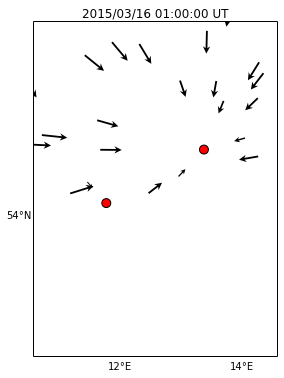

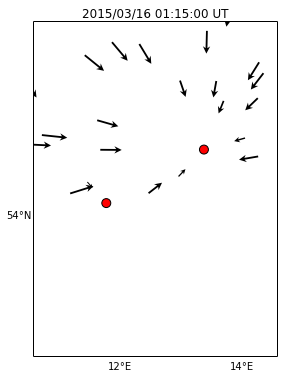

In [184]:
# Useful references for plotting code:
# http://matplotlib.org/api/text_api.html#matplotlib.text.Text
# http://matplotlib.org/api/font_manager_api.html#matplotlib.font_manager.FontProperties
# http://matplotlib.org/api/patches_api.html#matplotlib.patches.Patch

timestep = timestep_fit
Nq = 10. # approximately how many arrows across and down you want
WN = 4 # upsample factor for vertical wind color plot
figsize=(6,6) # 6,6
sc = figsize[1]/(Nq*200) # 1/Nq^th of the plot width <==> 250 m/s, for quiver
pivot = 'middle' # for quiver
headwidth = 4 # 3
headlength = 4 # 3
headaxislength= headlength-1
minshaft = 2
qcolor = 'k'

xs = linspace(lonmin, lonmax, Nq) # TODO: don't rely on lonmin rolling over from before
ys = linspace(latmin, latmax, Nq)

[Xq,Yq] = meshgrid(xs,ys)

# Start at a rounded time
start_t = windfield['t'][0]
t0 = start_t
t1 = start_t + timedelta(seconds=timestep)
timestepvec = range(0,int((t1-t0).total_seconds()+1), timestep)
            
for timeindex in range(len(timestepvec)):
    
    ####### PLOT #######
    t = start_t + timedelta(seconds = timestepvec[timeindex])
    
    # Load up the necessary values
    Uest = zeros((Nq,Nq))
    Vest = zeros((Nq,Nq))
    Uerr = zeros((Nq,Nq))
    Verr = zeros((Nq,Nq))
    Werr = zeros((Nq,Nq))
    for i in range(shape(Xq)[0]):
        for j in range(shape(Xq)[1]):
            (u,v,w,ue,ve,we,lam0,lam1,xm,ym) = eval_field(windfield, Xq[i,j], Yq[i,j], t)
            Uest[i,j] = u
            Vest[i,j] = v
            Uerr[i,j] = ue
            Verr[i,j] = ve
            Werr[i,j] = we
    
    fig = figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
                
    # Transform U,V to inches
    Uest = sc*Uest
    Vest = sc*Vest
    
    # setup Lambert Conformal basemap.
    m = Basemap(llcrnrlon=lonmin-0.2,llcrnrlat=latmin-0.5,urcrnrlon=lonmax+0.2,urcrnrlat=latmax+0.2,
            projection='merc', area_thresh=1000,
            resolution='i')
    #m.drawcoastlines()
    #m.fillcontinents(alpha=.5)
    #m.drawstates()

    
    # Plot Wind Field
    for jj in range(len(lats)):
        xpt,ypt = m(lons[jj],lats[jj])
        scq = 0.3
        Q1 = m.quiver(xpt,ypt, scq*kB[jj][0],scq*kB[jj][1], angles='uv', scale_units='inches', scale=1, 
                      pivot=pivot, headwidth=headwidth, headlength=headlength,
                      minshaft=minshaft, headaxislength=headaxislength, color=qcolor)

    for ii in range(len(lon0vec)): 
        xpt,ypt = m(lon0vec[ii],lat0vec[ii])
        m.scatter(xpt,ypt, c='r', s= 80, edgecolor='k')
    
    title('%s UT' % t.strftime('%Y/%m/%d %H:%M:%S'))
    m.drawparallels(np.arange(-90,90,2.),labels=[1,0,0,0],color='black',linewidth=0) # draw parallels
    m.drawmeridians(np.arange(0,360,2.),labels=[0,0,0,1],color='black',linewidth=0) # draw meridians
    
    fig.savefig('%s/bragg_vectors.png' % (pngdir),dpi=150)
    #fig.savefig('%s/%05i.eps' % (pngdir,timeindex))
    
    # To save memory, close the figure if we're making a lot of figures
    if len(timestepvec) > 20:
        close(fig)
    
    print '%i/%i %s' % (timeindex+1,len(timestepvec),t)
#print 'Done'

In [235]:
imshow(windfield['u'][0],interpolation='none')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f592049ef80>

<matplotlib.colorbar.Colorbar instance at 0x7f591bebcd88>

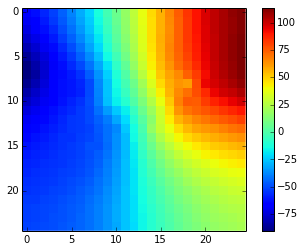

In [236]:
imshow(windfield['v'][0],interpolation='none')
colorbar()

In [28]:
zerr

array([  2.92091457,   7.10271155,   0.6752997 ,   3.91339209,
         0.67227644,   3.01165257,   5.64948234,   4.25465825,
         3.42724414,   3.06582258,   9.31055781,   3.4730089 ,
         5.00631034,   1.20581929,   9.08327549,   1.54342361,
         1.31637217,   6.51850605,   6.80009264,  21.16386105,
        14.05276954,   4.29563007,  15.34177629,   2.61825241,
         7.10895233,   2.73517163,   8.1307221 ,   1.87374199,
         3.26087015,   1.65874219,   4.24880208,  15.19749521,   1.03394443])

In [29]:
d.attrs.keys()

[u'PARAMETERS', u'OTHER']

In [42]:
par_desc = d.attrs['PARAMETERS'][0]
for i in range(len(par_desc)):
    print par_desc[i], d[300][i]

SNR lineal 6.83945
Total range (km) 12.28
UTC Time in seconds from 1970 1418864626
Time in fraction of second with respect to time UTC 20.4408
Doppler in Hz 6.67402
Doppler error in Hz 0.313366
Direction cosine in x -0.277569
Direction cosine in y 0.890235
Error in direction cosine x 0.252292
Error in direction cosine y 0.243213
decay parameter (1/s) 2.73087
Altitude (km) 87.751
Bragg vector (x,y,z) [ 0.65579379 -1.03774381 -0.48859382]


In [35]:
par_desc[0]

('SNR lineal', 'Total range (km)', 'UTC Time in seconds from 1970', 'Time in fraction of second with respect to time UTC', 'Doppler in Hz', 'Doppler error in Hz', 'Direction cosine in x', 'Direction cosine in y', 'Error in direction cosine x', 'Error in direction cosine y', 'decay parameter (1/s)', 'Altitude (km)', 'Bragg vector (x,y,z)')

In [ ]:
par_desc = d.attrs['PARAMETERS'][0]
for i in range(len(par_desc)):
    print par_desc[i], d[2][i]

In [38]:
d.attrs['OTHER']

array([(479.9999694824219, 32.54999923706055)], 
      dtype=[('IPP', '<f4'), ('FREQUENCY', '<f4')])

In [43]:
f.close()